In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Sat Jan 13 22:22:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |  17558MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 35%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-5/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


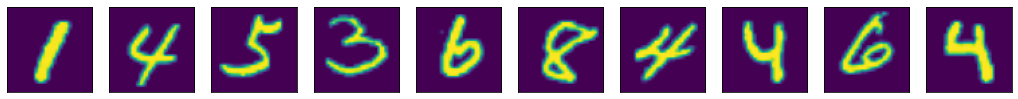

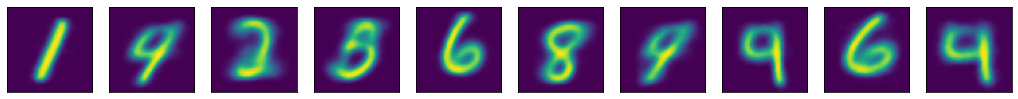

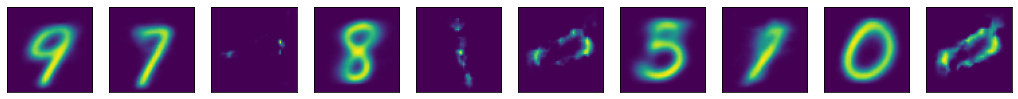

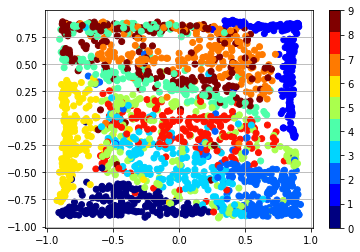

150001
lse_loss -0.5716971158981323
recon_loss 0.13060303032398224
150002
lse_loss -0.5084871649742126
recon_loss 0.12519191205501556
150003
lse_loss -0.5368965268135071
recon_loss 0.13878796994686127
150004
lse_loss -0.5483456254005432
recon_loss 0.12202721834182739
150005
lse_loss -0.5770119428634644
recon_loss 0.12859010696411133
150006
lse_loss -0.560750424861908
recon_loss 0.12684933841228485
150007
lse_loss -0.532280683517456
recon_loss 0.12899190187454224
150008
lse_loss -0.5561520457267761
recon_loss 0.12830284237861633
150009
lse_loss -0.5521515011787415
recon_loss 0.1308910846710205
150010
lse_loss -0.5302279591560364
recon_loss 0.13594046235084534
150011
lse_loss -0.5095820426940918
recon_loss 0.13146314024925232
150012
lse_loss -0.5357531309127808
recon_loss 0.1291879117488861
150013
lse_loss -0.5545318722724915
recon_loss 0.1355966180562973
150014
lse_loss -0.5421645045280457
recon_loss 0.11513411998748779
150015
lse_loss -0.47358909249305725
recon_loss 0.12908875942230225

150125
lse_loss -0.5432844758033752
recon_loss 0.11735737323760986
150126
lse_loss -0.5080580711364746
recon_loss 0.13974788784980774
150127
lse_loss -0.5378910303115845
recon_loss 0.13258324563503265
150128
lse_loss -0.5693544149398804
recon_loss 0.12787216901779175
150129
lse_loss -0.5150327682495117
recon_loss 0.12045039236545563
150130
lse_loss -0.5100704431533813
recon_loss 0.134132981300354
150131
lse_loss -0.5620126724243164
recon_loss 0.1232817992568016
150132
lse_loss -0.5684043169021606
recon_loss 0.13525545597076416
150133
lse_loss -0.4984716475009918
recon_loss 0.12295977771282196
150134
lse_loss -0.5113412141799927
recon_loss 0.12403225153684616
150135
lse_loss -0.5159668326377869
recon_loss 0.1286328136920929
150136
lse_loss -0.555610716342926
recon_loss 0.1320614516735077
150137
lse_loss -0.5458796620368958
recon_loss 0.12746118009090424
150138
lse_loss -0.5434935688972473
recon_loss 0.12311886250972748
150139
lse_loss -0.5446758270263672
recon_loss 0.13414530456066132
1

150250
lse_loss -0.5632474422454834
recon_loss 0.12674544751644135
150251
lse_loss -0.5347319841384888
recon_loss 0.12307377904653549
150252
lse_loss -0.5211135149002075
recon_loss 0.12770354747772217
150253
lse_loss -0.5073980093002319
recon_loss 0.1401025950908661
150254
lse_loss -0.5372115969657898
recon_loss 0.13712383806705475
150255
lse_loss -0.5493935942649841
recon_loss 0.12989991903305054
150256
lse_loss -0.49006518721580505
recon_loss 0.13620415329933167
150257
lse_loss -0.5304319858551025
recon_loss 0.1322830766439438
150258
lse_loss -0.5618224740028381
recon_loss 0.12633030116558075
150259
lse_loss -0.5567922592163086
recon_loss 0.13512100279331207
150260
lse_loss -0.49768364429473877
recon_loss 0.13505125045776367
150261
lse_loss -0.5191171169281006
recon_loss 0.13597778975963593
150262
lse_loss -0.5761827230453491
recon_loss 0.12587477266788483
150263
lse_loss -0.5510066151618958
recon_loss 0.12902499735355377
150264
lse_loss -0.5354077219963074
recon_loss 0.1343386620283

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=0.10)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        